In [ ]:
import keras
keras.__version__

'2.12.0'

# Rekurencyjne sieci neuronowe


## Warstwa rekurencyjna w pakiecie Keras


In [ ]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense, Embedding, GRU, Bidirectional
import numpy as np

Powyższa warstwa przyjmuje obiekty wejściowe o kształcie (rozmiar_wsadu, kroki_czasu, cechy_wejściowe).

Warstwa SimpleRNN, podobnie jak wszystkie rekurencyjne warstwy pakietu Keras, może być uruchomiona w dwóch trybach: może zwracać pełne sekwencje kolejnych obiektów wyjściowych dla każdego kroku czasu (trójwymiarowe tensory o kształcie (rozmiar_wsadu, kroki_czasu, cechy_wyjściowe)) lub tylko ostatnie obiekty wyjściowe poszczególnych sekwencji wejściowych (dwuwymiarowe tensory o kształcie (rozmiar_wsadu, cechy_wyjściowe)). Wybór trybu pracy jest dokonywany za pomocą argumentu return_sequences.

Teraz użyjmy modelu RNN w celu rozwiązania problemu klasyfikacji recenzji filmów. Zacznijmy od wstępnej obróbki danych:

In [ ]:
from keras.datasets import imdb
from keras.utils import pad_sequences

max_features = 10000  # Liczba słów traktowanych jako cechy.
maxlen = 500  # Ucina recenzje po tej liczbie słów.
batch_size = 128 # wielkość batcha
rnn_units = 32 # Liczba neuronów jaką będziemy wykorzystywać
max_samples = 1200 # Liczba danych treningowych *można podać mniej niż 25 000 aby sieć uczyła się szybciej

print('Ładowanie danych...')
(input_train_org, y_train), (input_test_org, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train_org), 'sekwencje treningowe')
print(len(input_test_org), 'sekwencje testowe')


Ładowanie danych...
17464789/17464789 [==============================] - 0s 0us/step
25000 sekwencje treningowe
25000 sekwencje testowe


In [ ]:
y_train[0]

1

(array([1.7598e+04, 5.3690e+03, 1.4070e+03, 5.1700e+02, 9.4000e+01,
        7.0000e+00, 5.0000e+00, 2.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  11. ,  259.3,  507.6,  755.9, 1004.2, 1252.5, 1500.8, 1749.1,
        1997.4, 2245.7, 2494. ]),
 <BarContainer object of 10 artists>)

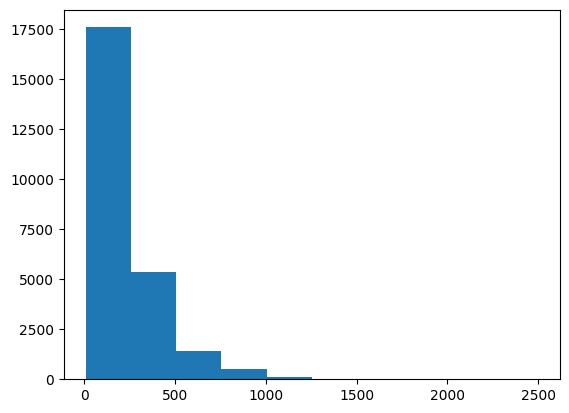

In [ ]:
#histogram długości sekwencji
import matplotlib.pyplot as plt
plt.hist([len(x) for x in input_train_org])

In [ ]:
print('Sekwencje (próbki x czas)')
input_train_org = input_train_org[:max_samples]
input_test_org = input_test_org[:max_samples]
input_train = pad_sequences(input_train_org, maxlen=maxlen)
input_test = pad_sequences(input_test_org, maxlen=maxlen)
print('Kształt obiektu input_train:', input_train.shape)
print('Kształt obiektu input_test:', input_test.shape)
y_train = y_train[:max_samples]
y_test = y_test[:max_samples]

Sekwencje (próbki x czas)
Kształt obiektu input_train: (1200, 500)
Kształt obiektu input_test: (1200, 500)


In [ ]:
input_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

Przeprowadźmy proces trenowania prostej rekurencyjnej sieci przy użyciu warstwy Embedding i warstwy SimpleRNN.

In [ ]:
y_train

{0, 1}

In [ ]:
input_train.shape

(1200, 500)

In [ ]:
model = Sequential()
# proszę dodać następujące warstwy:
# - warstwa Embedding z odpowiednią licznością wejścia
# (dla ilu słów musimy wyznaczyć reprezentację wektorową?) i wyznaczyć wielkość
# wektora embedding na 50
# - warstwa SimpleRNN z rnn_units jako liczbą neuronów
# - gęstą warstwę z jednym neuronem oraz funkcją aktywacji sigmoid
model.add(Embedding(max_features, 50))
model.add(SimpleRNN(rnn_units, return_sequences=False))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, None, 50)          100000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2656      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 102,689
Trainable params: 102,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# proszę skompilować model z oprimizerem RMSprop, odpowiednią funkcją kosztu oraz dokładnością jako metrykę do monitorowania
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# proszę wytrenować model, liczba epok 10, użyć zmiennej batch_size, ustawić validation_split na 0.2, można też spróbować
# ustawić liczbę instacji do obliczania (workers)
history = model.fit(input_train, y_train, epochs=10,
                    batch_size=batch_size, validation_split=0.2)


Epoch 1/10
8/8 [==============================] - 3s 208ms/step - loss: 0.6974 - acc: 0.5167 - val_loss: 0.7088 - val_acc: 0.4542
Epoch 2/10
8/8 [==============================] - 1s 182ms/step - loss: 0.6262 - acc: 0.7563 - val_loss: 0.7111 - val_acc: 0.4792
Epoch 3/10
8/8 [==============================] - 2s 207ms/step - loss: 0.5476 - acc: 0.8708 - val_loss: 0.7244 - val_acc: 0.4625
Epoch 4/10
8/8 [==============================] - 2s 300ms/step - loss: 0.4661 - acc: 0.9167 - val_loss: 0.7243 - val_acc: 0.4708
Epoch 5/10
8/8 [==============================] - 1s 180ms/step - loss: 0.4030 - acc: 0.9688 - val_loss: 0.7411 - val_acc: 0.4542
Epoch 6/10
8/8 [==============================] - 1s 178ms/step - loss: 0.3077 - acc: 0.9906 - val_loss: 0.7599 - val_acc: 0.4667
Epoch 7/10
8/8 [==============================] - 1s 169ms/step - loss: 0.2444 - acc: 0.9979 - val_loss: 0.7631 - val_acc: 0.5083
Epoch 8/10
8/8 [==============================] - 1s 172ms/step - loss: 0.2055 - acc: 0.99

Teraz możemy wyświetlić wykresy dokładności i straty w procesach trenowania i walidacji:

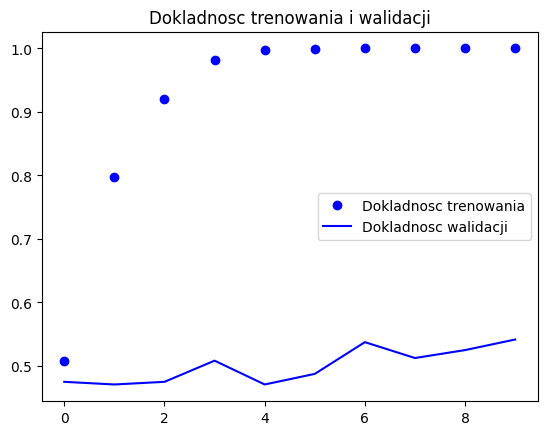

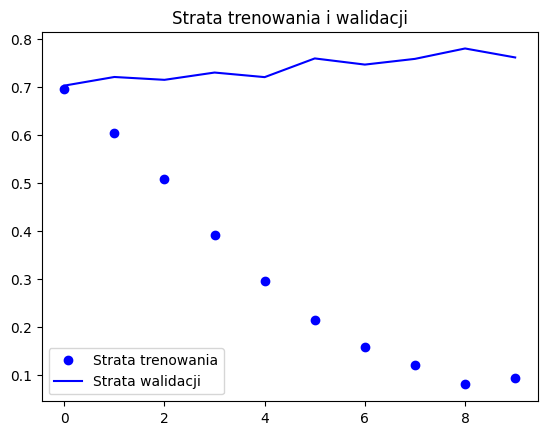

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

[...]

## Przykład warstwy LSTM zaimplementowanej w pakiecie Keras

Czas przyjrzeć się praktycznemu przykładowi zastosowania warstwy LSTM. Skonfigurujemy model, w którym znajdzie się taka warstwa, i wytrenujemy go na zbiorze danych IMDB. Przypomina on zaprezentowany wcześniej model z warstwą SimpleRNN. Określimy tylko liczbę wymiarów obiektu wyjściowego warstwy LSTM. Pozostałe argumenty tej warstwy (jest ich wiele) pozostawimy przy wartościach domyślnych. Ustawienia domyślne pakietu Keras są przemyślane i zwykle „po prostu działają” bez konieczności poświęcania dużej ilości czasu na ręczne dostrajanie parametrów.

In [ ]:
from keras.layers import LSTM

model = Sequential()
# proszę dodać następujące warstwy:
# - warstwa Embedding z odpowiednią licznością wejścia
# (dla ilu słów musimy wyznaczyć reprezentację wektorową?) i wyznaczyć wielkość
# wektora embedding na 50
# - warstwa LSTM z rnn_units jako liczbą neuronów
# - gęstą warstwę z 1 neuronem oraz funkcją aktywacji sigmoid
model.add(Embedding(max_features, 50))
model.add(LSTM(units=rnn_units))
model.add(Dense(1, activation='sigmoid'))
# model.add(Dense(2, activation='softmax'))


model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 50)          500000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                10624     
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 510,657
Trainable params: 510,657
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# proszę skompilować model z oprimizerem RMSprop, odpowiednią funkcją kosztu oraz dokładnością jako metrykę do monitorowania
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# proszę wytrenować model, liczba epok 10, użyć zmiennej batch_size, ustawić validation_split na 0.2, można też spróbować
# ustawić liczbę instacji do obliczania (workers)
history = model.fit(input_train, y_train, epochs=10,
                    batch_size=batch_size, validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 6s 445ms/step - loss: 0.6931 - acc: 0.5063 - val_loss: 0.6925 - val_acc: 0.4958
Epoch 2/10
8/8 [==============================] - 5s 619ms/step - loss: 0.6914 - acc: 0.5344 - val_loss: 0.6923 - val_acc: 0.5375
Epoch 3/10
8/8 [==============================] - 3s 380ms/step - loss: 0.6897 - acc: 0.6396 - val_loss: 0.6919 - val_acc: 0.5375
Epoch 4/10
8/8 [==============================] - 4s 507ms/step - loss: 0.6869 - acc: 0.6635 - val_loss: 0.6913 - val_acc: 0.5125
Epoch 5/10
8/8 [==============================] - 6s 734ms/step - loss: 0.6824 - acc: 0.6948 - val_loss: 0.6902 - val_acc: 0.5333
Epoch 6/10
8/8 [==============================] - 3s 358ms/step - loss: 0.6742 - acc: 0.7021 - val_loss: 0.6880 - val_acc: 0.5667
Epoch 7/10
8/8 [==============================] - 3s 361ms/step - loss: 0.6569 - acc: 0.7219 - val_loss: 0.6814 - val_acc: 0.5625
Epoch 8/10
8/8 [==============================] - 3s 366ms/step - loss: 0.6163 - acc: 0.69

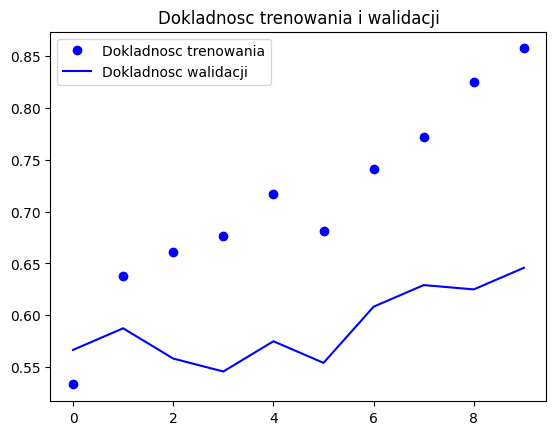

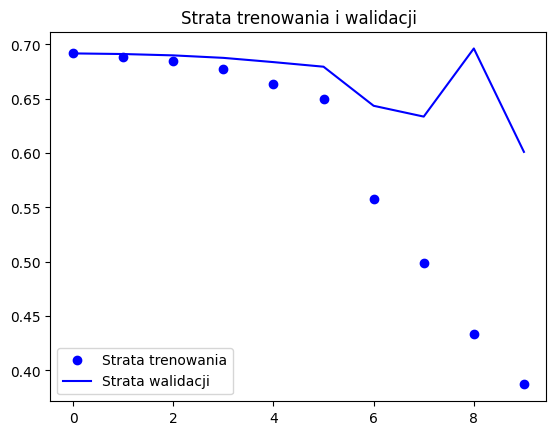

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

## Korzystanie z dwukierunkowych rekurencyjnych sieci neuronowych


Ostatnim rozwiązaniem, które chciałbym wprowadzić w tym podrozdziale, są dwukierunkowe rekurencyjne sieci neuronowe. Są to popularne wersje sieci rekurencyjnych, które w przypadku niektórych zadań charakteryzują się bardzo dobrą wydajnością. Stosuje się je często w przetwarzaniu języka naturalnego. Można określić je mianem uniwersalnego wytrychu sprawdzającego się podczas pracy nad problemami związanymi z przetwarzaniem języka naturalnego.

Rekurencyjne sieci neuronowe przetwarzają zależności wynikające z kolejności lub upływu czasu — przetwarzają one sekwencje w sposób uporządkowany. Zmiana kolejności obserwacji lub jej odwrócenie może całkowicie zmienić reprezentacje tworzone przez tego typu sieci. To właśnie z tego powodu sieci te sprawdzają się dobrze podczas rozwiązywania problemów, w których kolejność ma znaczenie (przykładem takiego problemu jest prognozowanie temperatury). Dwukierunkowe rekurencyjne sieci neuronowe korzystają z tej własności sieci rekurencyjnych. Składają się one z dwóch standardowych sieci rekurencyjnych (np. warstw GRU lub LSTM). Każda z tych sieci składowych przetwarza sekwencję wejściową w innym kierunku (chronologicznym lub przeciwnym do chronologicznego). Utworzone przez nie reprezentacje są następnie łączone. Dwukierunkowa sieć rekurencyjna, przetwarzając sekwencję w obu kierunkach, może wyłapać zależności, które nie są dostrzegane przez jednokierunkową sieć rekurencyjną.

Oczywiście chronologiczne przetwarzanie sekwencji przez zaprezentowane dotychczas warstwy sieci rekurencyjnych jest naszym nieświadomym wyborem (na razie nie mieliśmy okazji, aby podważyć jego sensowność). Czy sieci rekurencyjne działałyby wystarczająco dobrze, gdyby przetwarzały sekwencje wejściowe w kierunku odwrotnym do kolejności chronologicznej? Sprawdźmy to w praktyce, Wystarczy utworzyć generator, który odwraca sekwencję wejściową według wymiaru będącego osią czasu (musimy zastąpić ostatnią linię kodu następującym rozwiązaniem: yield samples[:, ::-1, :], targets). Po wytrenowaniu tej samej sieci z jedną warstwą GRU (z warstwy tej korzystaliśmy w pierwszym eksperymencie) uzyskamy następujące wyniki:

In [ ]:
# odwrócenie naszej sekwencji
input_train_rev = np.array([x[::-1] for x in input_train_org])
input_test_rev = np.array([x[::-1] for x in input_test_org])

input_train_rev = pad_sequences(input_train_rev, maxlen=maxlen)
input_test_rev = pad_sequences(input_test_rev, maxlen=maxlen)

model = Sequential()
# proszę dodać następujące warstwy:
# - warstwa Embedding z odpowiednią licznością wejścia (dla ilu słów musimy wyznaczyć reprezentację wektorową?)
# i 50 jako wielkość wektora
# - warstwa LSTM z rnn_units jako liczbą neuronów
# - gęstą warstwę z 1 neuronem (patrz wyjście) oraz funkcją aktywacji sigmoid
model.add(Embedding(max_features, 50))
model.add(LSTM(units=rnn_units))
model.add(Dense(1, activation='sigmoid'))


# proszę skompilować model z oprimizerem RMSprop, odpowiednią funkcją kosztu oraz dokładnością jako metrykę do monitorowania
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# proszę wytrenować model, liczba epok 10, użyć zmiennej batch_size, ustawić validation_split na 0.2, można też spróbować
# ustawić liczbę instacji do obliczania (workers)
history = model.fit(input_train_rev, y_train, epochs=10,
                    batch_size=batch_size, validation_split=0.2)

<ipython-input-48-bb5fa155d7e6>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_train_rev = np.array([x[::-1] for x in input_train_org])
<ipython-input-48-bb5fa155d7e6>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  input_test_rev = np.array([x[::-1] for x in input_test_org])


Epoch 1/10
8/8 [==============================] - 6s 445ms/step - loss: 0.6936 - acc: 0.4833 - val_loss: 0.6932 - val_acc: 0.5208
Epoch 2/10
8/8 [==============================] - 3s 382ms/step - loss: 0.6928 - acc: 0.5427 - val_loss: 0.6931 - val_acc: 0.5083
Epoch 3/10
8/8 [==============================] - 4s 528ms/step - loss: 0.6923 - acc: 0.5500 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 4/10
8/8 [==============================] - 3s 371ms/step - loss: 0.6917 - acc: 0.6042 - val_loss: 0.6928 - val_acc: 0.5375
Epoch 5/10
8/8 [==============================] - 3s 375ms/step - loss: 0.6908 - acc: 0.6010 - val_loss: 0.6925 - val_acc: 0.5125
Epoch 6/10
8/8 [==============================] - 3s 357ms/step - loss: 0.6897 - acc: 0.6146 - val_loss: 0.6919 - val_acc: 0.5500
Epoch 7/10
8/8 [==============================] - 4s 587ms/step - loss: 0.6873 - acc: 0.6333 - val_loss: 0.6911 - val_acc: 0.5417
Epoch 8/10
8/8 [==============================] - 3s 374ms/step - loss: 0.6840 - acc: 0.64

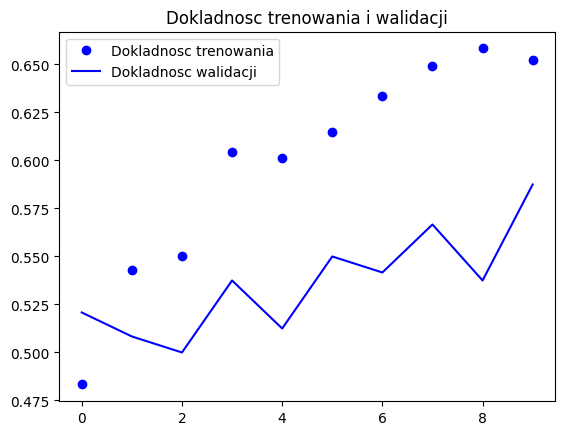

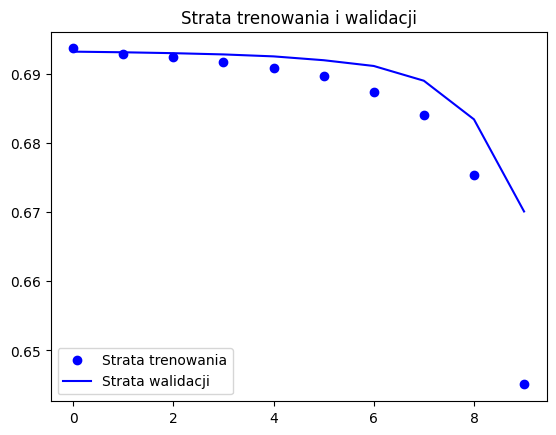

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

W celu utworzenia instancji dwukierunkowej sieci rekurencyjnej należy skorzystać z warstwy Bidirectional zaimplementowanej w pakiecie Keras, która jako swój pierwszy argument przyjmuje instancję warstwy rekurencyjnej. Funkcja Bidirectional tworzy drugą oddzielną instancję tej warstwy. Jedna instancja jest używana do przetwarzania sekwencji wejściowej w kierunku chronologicznym, a druga instancja jest używana do przetwarzania odwróconej sekwencji wejściowej. Wypróbujmy działanie tego rozwiązania w celu rozwiązania problemu analizy sentymentu recenzji filmów wchodzących w skład zbioru IMDB.

In [ ]:
model = Sequential()
# proszę dodać następujące warstwy:
# - warstwa Embedding z odpowiednią licznością wejścia (dla ilu słów musimy wyznaczyć reprezentację wektorową?)
# i 50 jako wielkość wektora
# - warstwa Bidirectional LSTM z rnn_units jako liczbą neuronów
# - gęstą warstwę z 1 neuronów (patrz wyjście) oraz funkcją aktywacji sigmoid
model.add(Embedding(max_features, 50))
model.add(Bidirectional(LSTM(units=rnn_units)))
model.add(Dense(1, activation='sigmoid'))


model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, None, 50)          500000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               21248     
 l)                                                              
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 521,313
Trainable params: 521,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# proszę skompilować model z oprimizerem RMSprop, odpowiednią funkcją kosztu oraz dokładnością jako metrykę do monitorowania
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# proszę wytrenować model, liczba epok 10, użyć zmiennej batch_size, ustawić validation_split na 0.2, można też spróbować
# ustawić liczbę instacji do obliczania (workers)
history = model.fit(input_train, y_train, epochs=10,
                    batch_size=batch_size, validation_split=0.2)

Epoch 1/10
8/8 [==============================] - 12s 970ms/step - loss: 0.6943 - acc: 0.4875 - val_loss: 0.6928 - val_acc: 0.5042
Epoch 2/10
8/8 [==============================] - 5s 686ms/step - loss: 0.6917 - acc: 0.5229 - val_loss: 0.6925 - val_acc: 0.5333
Epoch 3/10
8/8 [==============================] - 6s 831ms/step - loss: 0.6901 - acc: 0.6052 - val_loss: 0.6921 - val_acc: 0.5208
Epoch 4/10
8/8 [==============================] - 5s 644ms/step - loss: 0.6878 - acc: 0.5781 - val_loss: 0.6916 - val_acc: 0.5458
Epoch 5/10
8/8 [==============================] - 5s 681ms/step - loss: 0.6835 - acc: 0.6802 - val_loss: 0.6905 - val_acc: 0.5292
Epoch 6/10
8/8 [==============================] - 6s 734ms/step - loss: 0.6732 - acc: 0.6771 - val_loss: 0.6888 - val_acc: 0.5125
Epoch 7/10
8/8 [==============================] - 5s 688ms/step - loss: 0.6564 - acc: 0.6156 - val_loss: 0.6712 - val_acc: 0.5917
Epoch 8/10
8/8 [==============================] - 6s 786ms/step - loss: 0.5867 - acc: 0.7

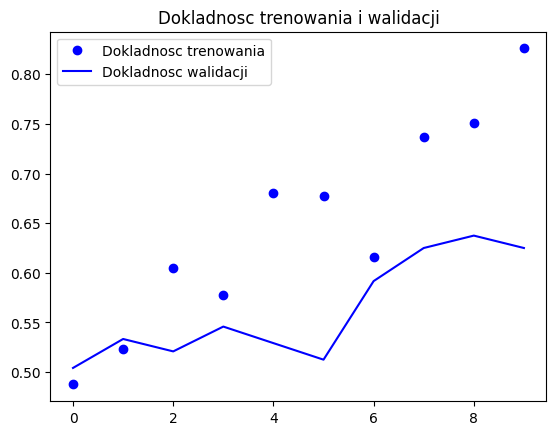

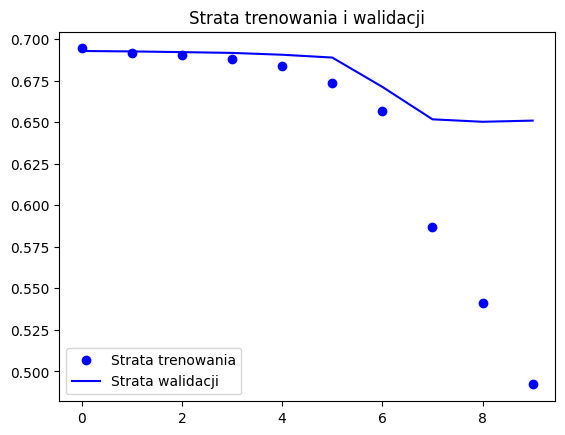

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

# Dropout

In [ ]:
model = Sequential()
# proszę dodać następujące warstwy:
# - warstwa Embedding z odpowiednią licznością wejścia (dla ilu słów musimy wyznaczyć reprezentację wektorową?)
# i 50 jako wielkość wektora
# - warstwa GRU z rnn_units jako liczbą neuronów oraz dropoutem 0.2 i recurent dropout 0.3
# - gęstą warstwę z 1 neuronem (patrz wyjście) oraz funkcją aktywacji sigmoid
model.add(Embedding(max_features, 50))
model.add(GRU(units=rnn_units, dropout=0.4, recurrent_dropout=0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 50)          500000    
                                                                 
 gru_4 (GRU)                 (None, 32)                8064      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 508,097
Trainable params: 508,097
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(input_train[0:3]).shape

1/1 [==============================] - 0s 228ms/step


(3, 1)

In [ ]:
# proszę skompilować model z oprimizerem RMSprop, odpowiednią funkcją kosztu oraz dokładnością jako metrykę do monitorowania
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# proszę wytrenować model, liczba epok 10, użyć zmiennej batch_size, ustawić validation_split na 0.2, można też spróbować
# ustawić liczbę instacji do obliczania (workers)
history = model.fit(input_train, y_train, validation_split=0.2,
                    epochs=10, batch_size=batch_size)

Epoch 1/10
8/8 [==============================] - 7s 575ms/step - loss: 0.5097 - acc: 0.7781 - val_loss: 0.6993 - val_acc: 0.5875
Epoch 2/10
8/8 [==============================] - 4s 437ms/step - loss: 0.4473 - acc: 0.8208 - val_loss: 0.7033 - val_acc: 0.5875
Epoch 3/10
8/8 [==============================] - 4s 440ms/step - loss: 0.3987 - acc: 0.8302 - val_loss: 0.7092 - val_acc: 0.6083
Epoch 4/10
8/8 [==============================] - 4s 518ms/step - loss: 0.3549 - acc: 0.8677 - val_loss: 0.7246 - val_acc: 0.6333
Epoch 5/10
8/8 [==============================] - 4s 435ms/step - loss: 0.3058 - acc: 0.8740 - val_loss: 0.7480 - val_acc: 0.6167
Epoch 6/10
8/8 [==============================] - 3s 436ms/step - loss: 0.2455 - acc: 0.9198 - val_loss: 0.7704 - val_acc: 0.6167
Epoch 7/10
8/8 [==============================] - 4s 477ms/step - loss: 0.2239 - acc: 0.9260 - val_loss: 0.7283 - val_acc: 0.6667
Epoch 8/10
8/8 [==============================] - 4s 468ms/step - loss: 0.1873 - acc: 0.93

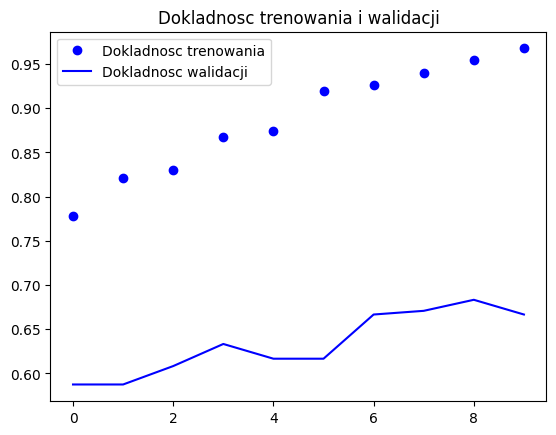

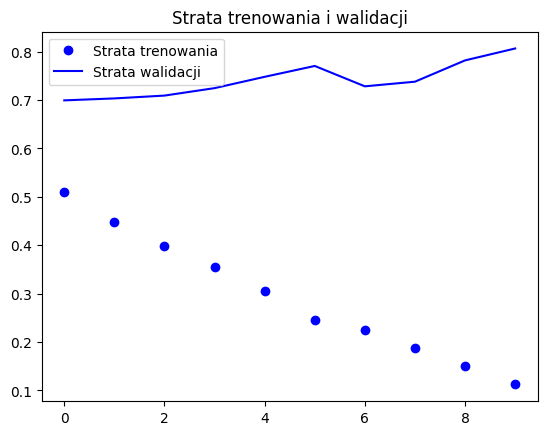

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()

# Tworzenie stosów warstw rekurencyjnych

In [ ]:
from keras.layers import Dropout
model = Sequential()
# proszę dodać następujące warstwy:
# - warstwa Embedding z odpowiednią licznością wejścia (dla ilu słów musimy wyznaczyć reprezentację wektorową?)
# i 50 jako wielkość wektora
# - warstwa GRU z rnn_units jako liczbą neuronów, przekazywaniem w głąb sieci sekwencji
# oraz dropoutem 0.1 i recurent dropout 0.5
# - warstwa GRU z rnn_units jako liczbą neuronów oraz dropoutem 0.2 i recurent dropout 0.4
# - gęstą warstwę z 1 neuronem (patrz wyjście) oraz funkcją aktywacji sigmoid
model.add(Embedding(max_features, 50))
model.add(GRU(units=rnn_units, dropout=0.1, recurrent_dropout=0.5, return_sequences=True))
model.add(GRU(units=rnn_units, dropout=0.2, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, None, 50)          500000    
                                                                 
 gru_11 (GRU)                (None, None, 32)          8064      
                                                                 
 gru_12 (GRU)                (None, 32)                6336      
                                                                 
 dense_7 (Dense)             (None, 1)                 33        
                                                                 
Total params: 514,433
Trainable params: 514,433
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# proszę skompilować model z oprimizerem RMSprop, odpowiednią funkcją kosztu oraz dokładnością jako metrykę do monitorowania
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# proszę wytrenować model, liczba epok 10, użyć zmiennej batch_size, ustawić validation_split na 0.2, można też spróbować
# ustawić liczbę instacji do obliczania (workers)
history = model.fit(input_train, y_train, validation_split=0.2,
                    epochs=10, batch_size=batch_size)

Epoch 1/10
8/8 [==============================] - 11s 996ms/step - loss: 0.6929 - acc: 0.5281 - val_loss: 0.6930 - val_acc: 0.5000
Epoch 2/10
8/8 [==============================] - 7s 849ms/step - loss: 0.6894 - acc: 0.5646 - val_loss: 0.6927 - val_acc: 0.5292
Epoch 3/10
8/8 [==============================] - 8s 973ms/step - loss: 0.6841 - acc: 0.6135 - val_loss: 0.6915 - val_acc: 0.5667
Epoch 4/10
8/8 [==============================] - 7s 826ms/step - loss: 0.6709 - acc: 0.7115 - val_loss: 0.6899 - val_acc: 0.4917
Epoch 5/10
8/8 [==============================] - 7s 897ms/step - loss: 0.6467 - acc: 0.7135 - val_loss: 0.6877 - val_acc: 0.5500
Epoch 6/10
8/8 [==============================] - 7s 943ms/step - loss: 0.5872 - acc: 0.7490 - val_loss: 0.6980 - val_acc: 0.5333
Epoch 7/10
8/8 [==============================] - 7s 818ms/step - loss: 0.5066 - acc: 0.7635 - val_loss: 0.7206 - val_acc: 0.5833
Epoch 8/10
8/8 [==============================] - 7s 929ms/step - loss: 0.4074 - acc: 0.8

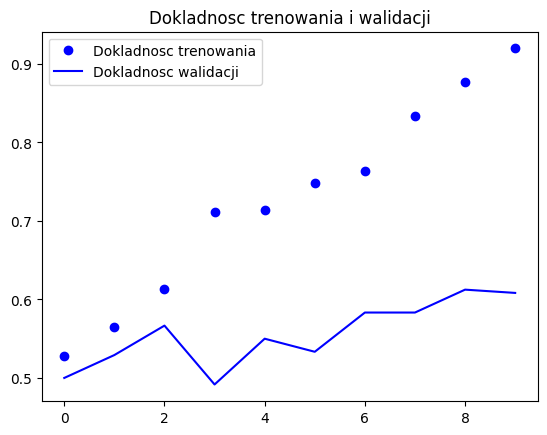

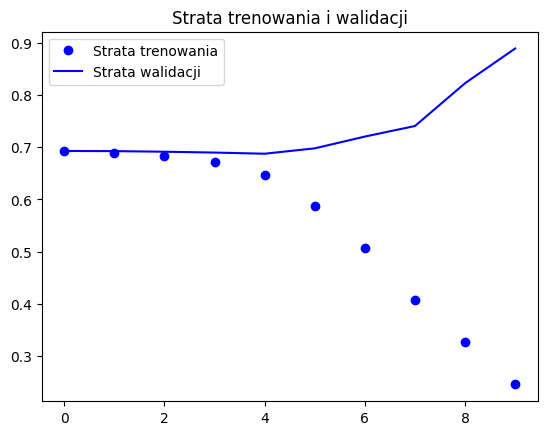

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Dokladnosc trenowania')
plt.plot(epochs, val_acc, 'b', label='Dokladnosc walidacji')
plt.title('Dokladnosc trenowania i walidacji')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Strata trenowania')
plt.plot(epochs, val_loss, 'b', label='Strata walidacji')
plt.title('Strata trenowania i walidacji')
plt.legend()

plt.show()